In [35]:
from dataAnalyzer import *
from private_tool import *
from dataHandler import *
from numpy import array

In [36]:
experimentNum = 9
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [37]:
channels = [7, 9, 10, 11]
samplingRate = 250 #Hz
trialsByClasses = array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [38]:
len(trialsByClasses[0]["left"][0])

69

In [39]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(4, 4)

In [40]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=5, 
                                                                cutoff_high=50)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [41]:
# bandpassedTrialsByClasses[2]["left"][2].shape

2
Hero
Paladin


In [42]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

C:\Users\jihun\AppData\Local\Temp\ipykernel_11200\3323506164.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bandpassedTrialsByClasses = {key:array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}


In [43]:
minTrialsNum = sorted([len(bandpassedTrialsByClasses["left"][i]) for i in range(experimentNum)])[0]
bandpassedTrialsByClasses = {i:bandpassedTrialsByClasses[i][0] for i in Experiments[0].mi_types.values()}

In [44]:
left_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["left"][0]), bandpassedTrialsByClasses["left"][0])
right_csp_filter = CSP_filter(len(bandpassedTrialsByClasses["right"][0]), bandpassedTrialsByClasses["right"][0])

ValueError: diag requires an array of at least two dimensions

In [45]:
len(bandpassedTrialsByClasses["left"]), len(bandpassedTrialsByClasses["right"])

(4, 4)

In [46]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i] 

In [47]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j.T@left_csp_filter for j in bandpassedTrialsByClasses["left"][0]]
CSP_passed_right_data = [j.T@right_csp_filter for j in bandpassedTrialsByClasses["right"][0]]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 69 is different from 1875)

In [ ]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [ ]:
print(array(CSP_passed_left_data).shape)
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]

(4, 1875, 69)


In [ ]:
array(CSP_passed_left_data).shape

(4, 69, 1875)

In [ ]:
from math import log
m = 2
print(len(CSP_passed_left_data))
# for i in range(minTrialsNum):
#     CSP_passed_left_data[i]
leftVar = np.array([np.array([np.var(CSP_passed_left_data[i][j]) for j in range(minTrialsNum)]) for i in range(channelNum)])
rightVar = np.array([np.array([np.var(CSP_passed_right_data[i][j]) for j in range(minTrialsNum)]) for i in range(channelNum)])

leftVarRatio = np.array([np.array([log(leftVar[i][j-m]/sum(leftVar[i])) for j in range(m*2)]) for i in range(channelNum)])
rightVarRatio = np.array([np.array([log(rightVar[i][j-m]/sum(rightVar[i])) for j in range(m*2)]) for i in range(channelNum)])

4


In [ ]:
leftVarRatioDF = pd.DataFrame(leftVarRatio)
rightVarRatioDF = pd.DataFrame(rightVarRatio)
labelDF = pd.DataFrame([0]*channelNum + [1]*channelNum)

In [ ]:
VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF], axis=0)
VarRatioDF = VarRatioDF.reset_index()
VarRatioDF = pd.concat([VarRatioDF, labelDF], axis=1).iloc[:,1:]
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
VarRatioDF

,0,1,2,3,target
0,-4.006609,-3.828681,-4.101242,-4.033960,0
1,-4.090508,-3.732472,-4.113244,-4.076087,0
2,-4.054104,-3.744143,-4.169380,-4.081331,0
3,-3.988417,-3.773423,-4.218823,-4.066461,0
4,-4.116012,-4.077987,-3.836805,-3.755975,1
5,-4.144991,-4.101030,-3.878388,-3.707654,1
6,-4.098983,-4.104210,-3.876317,-3.691179,1
7,-4.069806,-4.047110,-3.847742,-3.679556,1


In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler
x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3
0,1.294072,0.611103,-0.641189,-0.820936
1,-0.387389,1.214423,-0.721355,-1.055500
2,0.342213,1.141232,-1.096295,-1.084700
3,1.658676,0.957623,-1.426528,-1.001905
4,-0.898533,-0.952266,1.125014,0.726918
5,-1.479307,-1.096767,0.847276,0.995980
6,-0.557244,-1.116708,0.861109,1.087715
7,0.027512,-0.758639,1.051968,1.152428


In [ ]:
PCA = PrincipalComponentAnalysis(n_componunts=2, data=x)
principalDf = PCA.principalDf

In [ ]:
PCA.explained_variance_ratio_

<bound method PrincipalComponentAnalysis.explained_variance_ratio_ of <dataAnalyzer.PrincipalComponentAnalysis object at 0x00000166251CF640>>

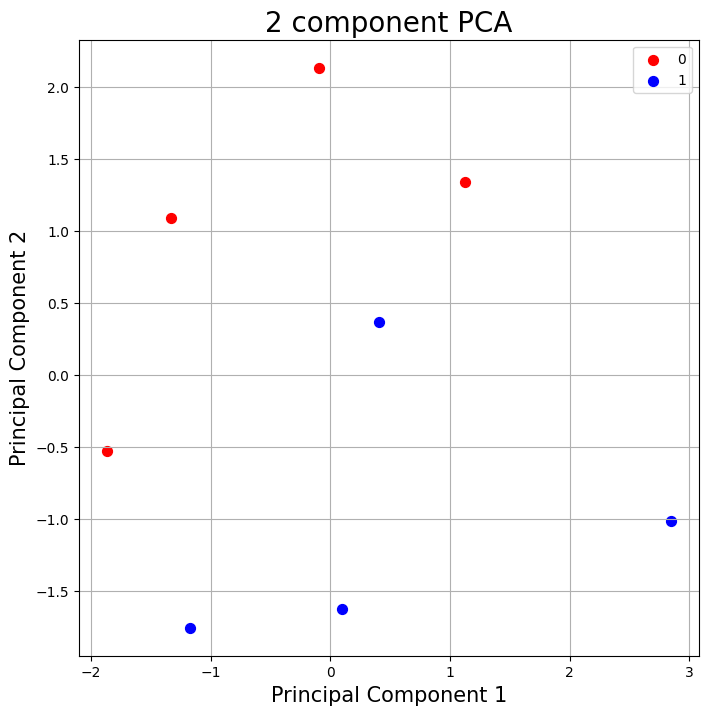

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize=20)

targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = VarRatioDF['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component1']
               , principalDf.loc[indicesToKeep, 'principal component2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()